In [1]:
import pickle
import numpy as np
import datetime as dt
import pandas as pd
from tpot import TPOTClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.metrics import PrecisionRecallDisplay
import seaborn as sns

In [2]:
fmat_file = '../ppi_ml/data/featmats/featmat_labeled.pkl'
featsel_file = '../ppi_ml/data/test_feat_labeling/featsel_xtrees_allres.csv'
n_feats2sel = 100
fdr_cutoff = 0.1
outdir = '../ppi_ml/results/test_walktrap/'

In [3]:
print(f'Reading in data ...')
with open(fmat_file, 'rb') as handle:
    fmat = pickle.load(handle)

fsel = pd.read_csv(featsel_file)
select_feats = fsel['feature'].head(n_feats2sel).tolist()
print(f'# feats selected: {len(select_feats)}')

label_cols = ['ID', 'label', 'super_group']
data_cols = [c for c in fmat.columns.values.tolist() if c not in label_cols and c in select_feats]

Reading in data ...
# feats selected: 100


In [23]:
def get_feature_subset(fmat, select_feats, label_cols, data_cols):
    fmat_subset = fmat[label_cols + data_cols]
    print(len(fmat_subset[(fmat_subset.super_group == 1) & (fmat_subset.label == 1)]))
    #fmat_subset.to_pickle('../ppi_ml/data/featmats/featmat_labeled_top100feats.pkl')
    #fmat_subset.to_csv('../ppi_ml/data/featmats/featmat_labeled_top100feats')

In [24]:
get_feature_subset(fmat, select_feats, label_cols, data_cols)

3815


In [5]:
def fmt_data(fmat, select_feats, subset, label_cols, data_cols, keep_groups=True):
    
    # get desired subset
    fmat_fmt = fmat[fmat['label'].isin(subset)]
    fmat_fmt.reset_index(inplace=True, drop=True)
    
    # format data for sklearn input
    X = fmat_fmt[data_cols].to_numpy()
    y = fmat_fmt[label_cols[1]].to_numpy()
    ids = fmat_fmt[label_cols[0]]
    
    if keep_groups:
        groups = fmat_fmt[label_cols[2]].to_numpy()
        return(X, y, ids, groups)
    else:
        return(X, y, ids)

In [6]:
X, y, ids, groups = fmt_data(fmat, select_feats, [1,-1], label_cols, data_cols, keep_groups=True)
X_pred, y_pred, ids_pred = fmt_data(fmat, select_feats, [0], label_cols, data_cols, keep_groups=False)

In [7]:
gss = GroupShuffleSplit(n_splits=3, train_size=0.7, random_state=13)
gss.get_n_splits()
for i, (test_idx, train_idx) in enumerate(gss.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"\tTrain: index={train_idx}, group={groups[train_idx]}")
    print(f"\tTest:  index={test_idx}, group={groups[test_idx]}")
    print(f"\t # train PPIs = {len(X[train_idx])}")
    print(f"\t # test PPIs = {len(X[test_idx])}")

Fold 0:
	Train: index=[    1     2     3 ... 25238 25239 25240], group=[ 1 31  1 ...  1  1  1]
	Test:  index=[    0     6     8 ... 25229 25230 25235], group=[511  17  17 ...  56  16  33]
	 # train PPIs = 18339
	 # test PPIs = 6902
Fold 1:
	Train: index=[    0     1     3 ... 25238 25239 25240], group=[511   1   1 ...   1   1   1]
	Test:  index=[    2     4     6 ... 25230 25232 25235], group=[31 47 17 ... 16 10 33]
	 # train PPIs = 17148
	 # test PPIs = 8093
Fold 2:
	Train: index=[    1     3     5 ... 25238 25239 25240], group=[1 1 1 ... 1 1 1]
	Test:  index=[    0     2     4 ... 25229 25230 25232], group=[511  31  47 ...  56  16  10]
	 # train PPIs = 17764
	 # test PPIs = 7477


In [8]:
for test_idx, train_idx in gss.split(X, y, groups):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

# check split & label balance
label, counts = np.unique(y_train, return_counts=True)
label_counts_train = dict(zip(label, counts))
label, counts = np.unique(y_test, return_counts=True)
label_counts_test = dict(zip(label, counts))
print(f'# train PPIs = {len(X_train)}')
print(f' --> +/- label balance: {label_counts_train}')
print(f'# test PPIs = {len(X_test)}')
print(f' --> +/- label balance: {label_counts_test}')

# train PPIs = 17764
 --> +/- label balance: {-1: 13180, 1: 4584}
# test PPIs = 7477
 --> +/- label balance: {-1: 5432, 1: 2045}


### Below is the optimized model as output by TPOT ... how to automate this step & make it generalizable to the command line?

In [9]:
clf = ExtraTreesClassifier(bootstrap=True, 
                           criterion="gini", 
                           max_features=0.7,
                           min_samples_leaf=3, 
                           min_samples_split=14, 
                           n_estimators=100,
                           n_jobs=8,
                           random_state=13)

In [10]:
clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, max_features=0.7, min_samples_leaf=3,
                     min_samples_split=14, n_jobs=8, random_state=13)

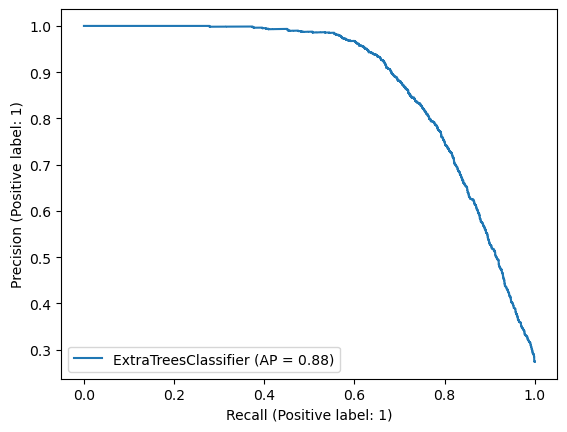

In [11]:
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

In [12]:
def calc_pr(df):
    
    print(f"Computing precision/recall ...")
    tp_count = 0
    fp_count = 0
    p_list = []
    r_list = []
    f_list = []
    all_pos = len(df[df['label'] == 1])

    for i in range(len(df)):

        if df['label'][i] == 1:
            tp_count += 1
        else:
            fp_count += 1

        tps = tp_count
        fps = fp_count
        fns = all_pos - tps

        precision = tps/(tps+fps)
        recall = tps/(tps+fns)
        fdr = 1 - precision

        p_list.append(float(precision))
        r_list.append(float(recall))
        f_list.append(float(fdr))

    df['precision'] = p_list
    df['recall'] = r_list
    df['fdr'] = f_list
    
    return(df)

In [13]:
def get_scores(model, array, labels, ids):
    
    # predict probability scores
    scores = model.predict_proba(array)
    probabilities = np.split(scores, 2, axis=1)
    neg_prob = probabilities[0]
    pos_prob = probabilities[1]
    
    # format into df
    df = pd.DataFrame()
    df['ID'] = ids
    df['label'] = labels
    df['ppi_score'] = pos_prob
    df.sort_values('ppi_score', inplace=True, ascending=False)
    df.reset_index(inplace=True, drop=True)
    
    return(df)

In [14]:
def threshold_ppis(test_scores, all_res, outdir, fdr_cutoff):
    
    print(f'FDR cutoff: {int(fdr_cutoff*100)}%')
    test_scores_pr = calc_pr(test_scores)
    pr_outfile = outdir+'testset_precision_recall.csv'
    print(f'Writing precision-recall results to {pr_outfile} ...')
    test_scores_pr.to_csv(pr_outfile)
    
    thres_df = test_scores_pr[test_scores_pr['fdr'] <= fdr_cutoff]
    prob_cutoff = min(thres_df['ppi_score'])
    print(f'PPI score cutoff for {int(fdr_cutoff*100)}% FDR: {prob_cutoff}')
    
    thres_df = all_res[all_res['ppi_score'] >= prob_cutoff]
    ids = thres_df['ID'].str.split(' ', expand=True)
    uniq_prots = np.unique(ids[[0, 1]].values)
    df_out = thres_df[['ID','ppi_score']]
    
    print(f'# total PPIs evaluated: {len(all_res)}')
    print(f'# PPIs above threshold: {len(thres_df)}')
    print(f'# unique proteins above threshold: {len(uniq_prots)}')
    
    return(df_out)

In [15]:
test_ids = ids[test_idx]
train_ids = ids[train_idx]
pred_ids = ids_pred

In [16]:
print(f"Getting probability scores ...")
test_scores = get_scores(clf, X_test, y_test, test_ids)
train_scores = get_scores(clf, X_train, y_train, train_ids)
pred_scores = get_scores(clf, X_pred, y_pred, pred_ids)

test_scores['set'] = 'test'
train_scores['set'] = 'train'
pred_scores['set'] = 'predict'

all_res = pd.concat([test_scores, train_scores, pred_scores])
all_res.sort_values('ppi_score', inplace=True, ascending=False)
all_res.reset_index(inplace=True, drop=True)
all_outfile = outdir+f'ppi_scores_all.csv'
print(f'Writing all results to {all_outfile} ...')
all_res.to_csv(all_outfile, index=False)

high_conf_ppis = threshold_ppis(test_scores, all_res, outdir, fdr_cutoff)
thres_outfile = outdir+f'ppi_scores_fdr{int(fdr_cutoff*100)}.csv'
print(f'Writing thresholded results to {thres_outfile} ...')
high_conf_ppis.to_csv(thres_outfile, index=False)

Getting probability scores ...
Getting probability scores ...
Getting probability scores ...
Writing all results to ../ppi_ml/results/test_walktrap/ppi_scores_all.csv ...
FDR cutoff: 15%
Computing precision/recall ...
Writing precision-recall results to ../ppi_ml/results/test_walktrap/testset_precision_recall.csv ...
PPI score cutoff for 15% FDR: 0.4181695121352377
# total PPIs evaluated: 4491718
# PPIs above threshold: 143341
# unique proteins above threshold: 3682
Writing thresholded results to ../ppi_ml/results/test_walktrap/ppi_scores_fdr15.csv ...
